# Predicting Job Satisfaction of Software Developers
In this research project a classification model will be created that tries to predict the Job Satisfaction of Software Developers using the survey results from the Stack Overflow survey of 2018.

## 1. Describing the dataset
[Stack Overflow](https://stackoverflow.com/) is a website where you can ask and answer software related questions. It is a platform where millions of programmers, software developers, software engineers, etc. meet every day to learn form each other. Stack Overflow itself is aware of the enormous popularity of their platform and for this reason they keep a annual survey to get general insight about the average software engineer in relation to his/her field of work.

Every year the results of the survey will get published on their website (cleaned and in csv format). Multiple datasets (one for each year since 2015) are available for analysis. For this project the survey results of 2018 will be used exclusively. The main reason for this choice is recency and the completeness of the results. The 2018 survey results were filled in by around 100.000 software developers, most of which answered 129 different questions. These questions are about job satisfaction, salary, favourite programming languages, weekly exercise, company size, etc. This large variety of questions provides a source of interesting research opportunities.

**Source of the dataset**<br />
Stack Overflow Developer Survey 2018 (186 MB): https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey


**Data description:**<br />
The Stack Overflow survey results of 2018 has in total 98855 rows and 129 columns. Some of these columns consist of only numerical data, like: 'Salary' and 'ConvertedSalary'. All the other columns are categorical. The categorical columns are devidable over three types of columns:
- Values denoted in text. E.g. 'Yes', 'No', 'United States', 'Employed part-time', etc.
- Values denoted in ';' seperated lists. E.g. 'Python;Java;C#', 'Windows;Linux;, etc.
- Values denoted in numbers. E.g. 1, 2, 3, 4, etc. (for rankings)

Textual input can't be interpreted easily by the average Machine Learning algorithm. Therefore, preprocessing of the original dataset is needed, so it can be used for further analysis. A [notebook](./dataset_preprocessing.ipynb) is created that is dedicted to preprocessing the Stack Overflow survey dataset in the following ways:
- Drop rows with missing values in the column 'JobSatisfaction'. The column 'JobSatisfaction' is the target value that will be used for analysis. It is not desirable to have missing values for a target feature, because the value NaN doesn't refer to valid classification value.
- Drop unimportant columns. Some columns can be left out because they have no correlation with the target column 'JobSatisfaction', are redundant or have too many missing values (80%).
- Preprocess values dentoed in ';' seperated lists. List values such as 'Python;Java;C#' can't be used as input for a Machine Learning algorithm. First, the value has to be numerical. Second, numerification of the ';' value as is will result a unique class for every unique list. It is instead needed to get a unique class for every language present in the list.
- Encode text to numerical values. Text isn't easy to interpret for Machine Learning algorithms. To solve this problem all text-formatted values will be converted to numerical values.
- Impute missing values. A lot of data is missing, this missing data can be imputed with statistical values (e.g. mean, mode, etc.)

The above steps will result in a preprocessed data set with 69276 rows and 410 columns.<br />
The data will be tranformed as follows:<br />

| Student | Programming Language | Country        |
|:-------:|:--------------------:|:--------------:|
| Yes     | Python;Java;C#       | Kenya          |
| No      | Python;C#            | United Kingdom |
| Yes     | Java;C#              | United States  |

| Student | Python | Java | C# | Country |
|:-------:|:------:|:----:|:--:|:-------:|
| 1       | 1      | 1    | 1  | 0       |
| 0       | 1      | 0    | 1  | 1       |
| 1       | 0      | 1    | 1  | 2       |

## 2. Defining research
Research will be conducted on the job satisfaction of software developers. The dataset, as described above, will be used to create a classifaction model that predicts the job statisfaction of software developers. The following research question will be answered:

**Can an accurate model be created, given the features denoted in the survey, to predict the job satisfaction of software developers?**

The model will be seen as accurate if at least 90% of the predictions are the same as the target values (column 'JobSatisfaction'). On top of the research question, a initial hypothesis can be made:

**Salary and career satisfaction are the main influencors of job satisfaction, and is therefore responsible for a high accuracy classification model.**

This hypothesis will be either approved or rejected accoring to the reseach results.

## 3. Exploration
Initial exploration of the data gives insight of the data itself and a better intuiting while conducting the research.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 3.1. Import the preprocessed dataset

In [2]:
# Import preprocessed dataset
so_survey = pd.read_csv('./dataset/so_survey_prepped.csv')

# Import the mappings for decoding purposes
so_mappings = pd.read_csv('./dataset/so_survey_mappings.csv')

In [3]:
# Show first three entries of so_survey data frame
so_survey.head(3)

,CompanySize,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,...,"EducationParents%Bachelor’s degree (BA, BS, B.Eng., etc.)","EducationParents%Master’s degree (MA, MS, M.Eng., MBA, etc.)","EducationParents%Other doctoral degree (Ph.D, Ed.D., etc.)",EducationParents%Primary/elementary school,"EducationParents%Professional degree (JD, MD, etc.)","EducationParents%Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",EducationParents%Some college/university study without earning a degree,EducationParents%They never completed any formal education,Dependents%No,Dependents%Yes
0,2.0,1.0,1,6,6,10.0,7.0,8.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.0,9.0,5,1,3,1.0,7.0,10.0,8.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.0,7.0,2,5,5,9.0,9.0,8.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# Show first three entries of so_mappings data frame
so_mappings.head(3)

,CompanySize,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,TimeFullyProductive,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,NumberMonitors,...,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,HoursComputer,HoursOutside,SkipMeals,Exercise,Age
0,Fewer than 10 employees,0-2 years,0-2 years,Extremely dissatisfied,Extremely dissatisfied,Less than a month,Strongly disagree,Strongly disagree,Strongly disagree,1,...,Not at all interested,Not at all interested,Not at all interested,Not at all interested,Not at all interested,Less than 1 hour,Less than 30 minutes,Never,I don't typically exercise,Under 18 years old
1,10 to 19 employees,3-5 years,3-5 years,Moderately dissatisfied,Moderately dissatisfied,One to three months,Disagree,Disagree,Disagree,2,...,A little bit interested,A little bit interested,A little bit interested,A little bit interested,A little bit interested,1 - 4 hours,30 - 59 minutes,1 - 2 times per week,1 - 2 times per week,18 - 24 years old
2,20 to 99 employees,6-8 years,6-8 years,Slightly dissatisfied,Slightly dissatisfied,Three to six months,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,3,...,Somewhat interested,Somewhat interested,Somewhat interested,Somewhat interested,Somewhat interested,5 - 8 hours,1 - 2 hours,3 - 4 times per week,3 - 4 times per week,25 - 34 years old


### 3.2. Create decode  and encode function
In advance, a generic decode and encode function will be created

In [5]:
def decode_labels(labels, column_name, decoder=so_mappings):
    """ Decodes encoded (preprocessed) labes using a decoder.
    E.g. [0, 1, 0, 0] for column 'Hobby' => ['Yes', 'No', 'Yes', 'Yes']
    """
    decoded_labels = so_mappings[column_name].values
    return [decoded_labels[i] for i in labels]

def encode_labels(labels, column_name, encoder=so_mappings):
    """ Encoded decoded labes using an encoder.
    E.g. ['Yes', 'No', 'Yes', 'Yes'] for column 'Hobby' => [0, 1, 0, 0]
    """
    decoded_labels = so_mappings[column_name].values.tolist()
    return [decoded_labels.index(l) for l in labels]

### 3.3. Distribution of salary
Lets see how salary is distributed.

In [6]:
# Make a data frame with column 'ConvertedSalary' and NaN values filtered out
mask = pd.isnull(so_survey['ConvertedSalary']) == False
salaries = so_survey['ConvertedSalary'][mask].values

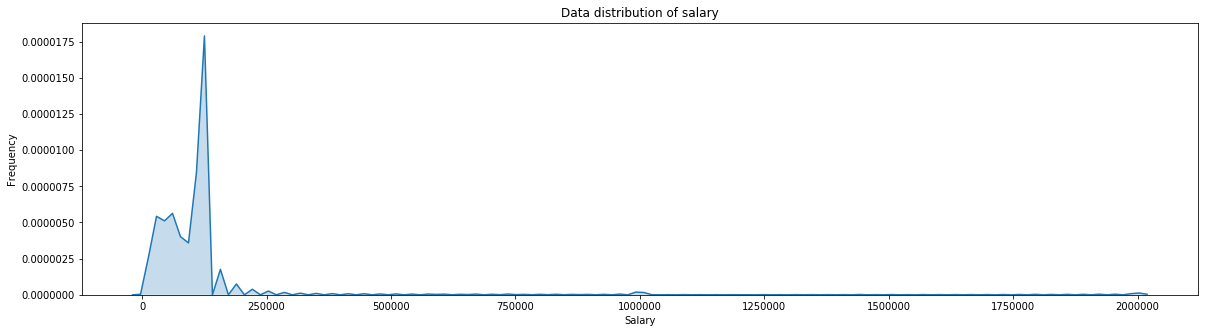

In [7]:
# Plot salary distribution
plt.figure(figsize=(20,5))
kde = sns.kdeplot(salaries, shade=True)
kde.set(title='Data distribution of salary', 
        xlabel='Salary', ylabel='Frequency');

The distribution of salary appears the be very skewed. To reduce the skew, log transformation can be applied on the salaries. But before we can do this, the salaries with value zero needs to be filtered out (logarithm of zero is impossible).

In [8]:
salaries = np.log(salaries[salaries != 0])

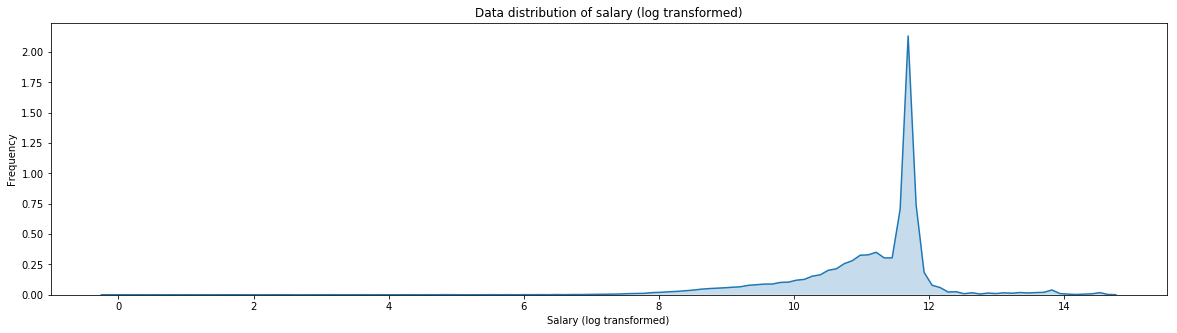

In [9]:
# Plot salary distribution (log transformed)
plt.figure(figsize=(20,5))
kde = sns.kdeplot(salaries, shade=True)
kde.set(title='Data distribution of salary (log transformed)', 
        xlabel='Salary (log transformed)', 
        ylabel='Frequency');

The data distribution has now more the appearance of a gaussian distribution (bell curve shape). Although, the data is still skewed due to the outliers. If the many outliers will cause the classification model to perform badly, the outliers will be removed. This can be done, for example, by pruning the data by $x$ times the standard deviation of the salaries.

## 4. Analysis
In this part, some classifiction algorithms will be trained to predict the job satisfaction of software developers. This will be done by implementing the following strategy:
1. Loosely optimize the hyperparameters of a classifier that will be used in the feature selection part. This prevents selecting features with e.g. an overfitted/underfit model.
2. Selecting features with the finetuned classifier. (feature selection is necessary since training classifiers with 409 features and more than 10000 rows is extremely time consuming) 
3. Use the selected features to train and finetune different classifiers.
4. Compare the performance of the different models.

In [10]:
# Import necessary sklearn libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### 4.1. Setup the features and target values

In [11]:
# Set target (y) 
target = 'JobSatisfaction'
y = so_survey[target]

In [12]:
# Set features (X)
features = [x for x in so_survey.columns if x != target]
X = so_survey[features]

### 4.2. Perform feature scaling
A min max scaler will be used to scale the features to values between 0 and 1, resulting in all features having values within the same range. This has some benefits:
+ All features have the same 'weight'. This will help algorithms like SVM (with Gaussian kernel) to perform better.
+ Speeds up gradient descent while training.
+ Improves insight in coefficients. If all features have the same 'weight', resulting coefficient will describe the influence of feature on the target better. This is useful for feature selection.

In [13]:
# Perform feature scaling with min max scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

### 4.3. Split into training and testing set
The features and target values will be split into training and testing sets.
The training set will contain 75% of the dataset (randomly selected rows)
The testing set will therefore contain 25% of the dataset.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 4.4. Loosely optimize hyperparameters
The Random Forest classifier will be used as an estimator for the feature selection step. This has the following benefits:
+ Popular feature selection algorithms like RFE or RFECV are recursively training a classifier. This will take a lot of time. Decision Trees are faster than classifiers such as Neural Networks or Support Vector Machines. 
+ By using a Random Forest the main drawback of Decision Trees (overfitting the training set) will be (partly) solved.
+ It isn't known if the classes are linear separatable. A Random Forest is both a linear and a non-linear classifier.
<br><br>The RandomizedSearch method will be used in contrast to GridSearch, because RandomizedSearch doesn't compute all possible computations (hence 'loosely') and is therefore computationally inexpensive.

In [15]:
# Import Random Forest classifier and RandomizedSearchCV algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [16]:
# Define ranges for several of the Random Forest hyperparameters
n_estimators = np.arange(50, 250, 50)
max_depth = [5]
min_samples_split = np.arange(50, 105, 5)
min_samples_leaf = np.arange(20, 55, 5)

In [17]:
# Create the random grid with defined hyperparameter ranges
random_grid = { 'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf }
# Print grid
[print('%s: %s' % x) for x in random_grid.items()];

n_estimators: [ 50 100 150 200]
max_depth: [5]
min_samples_split: [ 50  55  60  65  70  75  80  85  90  95 100]
min_samples_leaf: [20 25 30 35 40 45 50]


In [18]:
# Train default RandomForestClassifier for comparison
default_score = np.sum(cross_val_score(RandomForestClassifier(random_state=21), X, y, cv=3)) / 3

# Print default cross-validated score
print('Mean cross-validated score of the default estimator: %0.3f' % (default_score))

Mean cross-validated score of the default estimator: 0.358


In [19]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_estimator = RandomForestClassifier(random_state=21)
# Random search of parameters, using 5 fold cross validation, 
# search across 10 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator=rf_estimator, 
                                   param_distributions=random_grid, 
                                   n_iter=25, 
                                   cv=3, 
                                   verbose=1, 
                                   random_state=21, 
                                   n_jobs=-1)

# Fit the random search model
random_search = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.1min finished


In [20]:
# Print best cross-validated score
print('Mean cross-validated score of the best estimator: %0.3f' % (random_search.best_score_))
print('Improvement relative to default mean cross-validated score: : %0.3f' % (random_search.best_score_ - default_score))

# Show best parameters
best_random_rf_params = random_search.best_params_
best_random_rf_params

Mean cross-validated score of the best estimator: 0.373
Improvement relative to default mean cross-validated score: : 0.015


{'n_estimators': 50,
 'min_samples_split': 55,
 'min_samples_leaf': 20,
 'max_depth': 5}

### 4.5. Feature selection
The datasets contain 409 features an more than 10000 rows. Training with such an amount of features can take a very long time for algorithms like SVM (expontential time complexity). The training process becomes much faster by pruning redundant features or by reducing dimensionality. 

#### 4.5.1. RFECV (Recursive Feature Elimination with Cross-Validation)
RFE is a method that uses an estimator (in this case a classifier) that assigns weights to features (coefficients). The goals is to recursively select features by considering smaller and smaller sets of features. The least important features are pruned from the current set of features. The CV is used to make a selection of the best number of features.<br>
The estimator that will be used is the Random Forest classifier.

In [21]:
# Import RFECV algorithm
from sklearn.feature_selection import RFECV

In [22]:
# Instantiate Random Forest classifier using the 'best' (loosely) hyperparameters
rf_estimator = random_search.best_estimator_ 

In [23]:
# Instantiate the RFECV algorithm
f_selector = RFECV(estimator=rf_estimator,
                   step=1,
                   verbose=2,
                   cv=3,
                   n_jobs=-1)

In [24]:
# Fit the RFECV algorithm
f_selector = f_selector.fit(X_train, y_train)

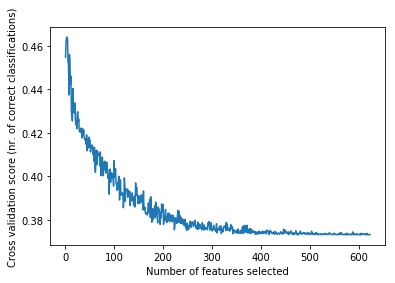

In [25]:
# Plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nr. of correct classifications)")
plt.plot(range(1, len(f_selector.grid_scores_) + 1), f_selector.grid_scores_)
plt.show()

In [26]:
# Show best number of features
print('Optimal number of features: %i' % (f_selector.n_features_))

Optimal number of features: 4


In [27]:
# Create a dataframe that shows the ranking of features
def create_ranking_df(ranking_list, columns):
    ranking = {}
    for i in range(len(ranking_list)):
        rank = ranking_list[i]
        col = columns[i]
        if rank in ranking:
            ranking[rank].append(col)
        else:
            ranking[rank] = [col]
    ranking = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in ranking.items()]))
    return ranking.reindex(sorted(ranking.columns), axis=1)

In [28]:
# Show ranking
ranking = create_ranking_df(f_selector.ranking_, X.columns)

#### 4.5.2. Use selected featues
The selected features will be used to create a new training ands test set.
CareerSatisfaction and ConvertedSalary will be added to the selection if they are nog in the selection yet. This is because the two values are needed to promote or reject the hypothesis.

In [29]:
# Get indeces of best selection of features
best_features = [i for i, rank in enumerate(f_selector.ranking_) if rank == 1]

# Get indexes of 'CareerSatisfaction' and 'ConvertedSalary'
satisfaction = [i for i, col in enumerate(X.columns) if col == 'CareerSatisfaction'][0]
salary= [i for i, col in enumerate(X.columns) if col == 'ConvertedSalary'][0]

# If index is not yet in selection: add it to selection
if satisfaction not in best_features: best_features.append(satisfaction)
if salary not in best_features: best_features.append(salary)

In [30]:
X_train_best = X_train[:,best_features]
X_test_best = X_test[:,best_features]

### 4.6. Train different classifiers using selected features
In this section the following classifiers will be fine tuned and trained to predict job satisfaction:
+ Random Forest

In [31]:
# Import GridSearchCV algorithm to select best combination of hyperparameters
from sklearn.model_selection import GridSearchCV

# Import leaning_curve and validation_curve to evaluate trained models
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [39]:
# Define a function for plotting learning curves:
# Learning curves show the learning rate of the training and 
# cross-validation set over training examples (m).
def plot_learning_curve(estimator, title, X, y):    
    # Fit to get parameters for the learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator,
        X, y, cv=3, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy', n_jobs=-1)
    
    # Get mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # Get mean and standard deviation for cross-validation scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Setup chart
    plt.figure()
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Score (accuracy)')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='b')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='b',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label='Cross-validation score')
    plt.legend(loc='best')

    return plt

In [40]:
# Define a function for plotting validation curves:
# Validation curves show the learning rate of the training and 
# cross-validation set over a range of values of a defined hyperparameter.
def plot_validation_curve(estimator, title, X, y, param_range, param_name):
    # Fit to get parameters for the validation curve
    train_scores, test_scores = validation_curve(estimator,
        X, y, cv=3, param_name=param_name, param_range=param_range, scoring='accuracy', n_jobs=-1)
    
    # Get mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Get mean and standard deviation for cross-validation scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Setup chart
    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Score (accuracy)')
    plt.grid()
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='g', lw=2)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color='r', lw=2)
    plt.plot(param_range, train_scores_mean, 'o-', color='g',
         label='Training score')
    plt.plot(param_range, test_scores_mean, 'o-', color='r',
             label='Cross-validation score')
    plt.legend(loc='best')
    
    return plt

In [34]:
def metrics(X, y, classifier, show=True):
    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro', labels=np.unique(y_pred))
    precision = precision_score(y, y_pred, average='macro', labels=np.unique(y_pred))
    recall = recall_score(y, y_pred, average='macro', labels=np.unique(y_pred))
    if show:
        print('Accuracy on test set: %0.3f' % (accuracy))
        print('F1-score on test set: %0.3f' % (f1))
        print('Precision on test set: %0.3f' % (precision))
        print('Recall on test set: %0.3f' % (recall))
    return accuracy, f1, precision, recall

#### 4.6.1 Random Forest
The Random Forest classifier is used before for features selection. This time the Random Forest classifier will be used to predict the job satisfaction using the selected features.
First, the default Random Forest classifier will trained on the training set and evaltuated.
After the evaluation, a second Random Forest will be used to select the optimal hyperparameters.
The Random Forest classifier containing the optimal hyperparamaters will be evaluated on high variance (overfitting) and high bias (underfitting).<br>
The following hyperparameters will be optimized:
+ n_estimators: The number of trees in the forest.
+ max_depth: The maximum depth of the tree.
+ min_samples_split: The minimum number of samples required to split an internal node.
+ min_samples_leaf: The minimum number of samples required to be at a leaf node.

##### Default

In [35]:
rf_clf_default = RandomForestClassifier(random_state=21)
rf_clf_default_score = np.sum(cross_val_score(rf_clf_default, X_train_best, y_train, cv=5)) / 5

print('Mean cross-validated score of random forest with default parameters: %0.3f' % (rf_clf_default_score))

Mean cross-validated score of random forest with default parameters: 0.412


In [36]:
rf_clf_default.fit(X_train_best, y_train)
rf_clf_default_metrics = metrics(X_test_best, y_test, rf_clf_default);

Accuracy on test set: 0.413
F1-score on test set: 0.317
Precision on test set: 0.333
Recall on test set: 0.312


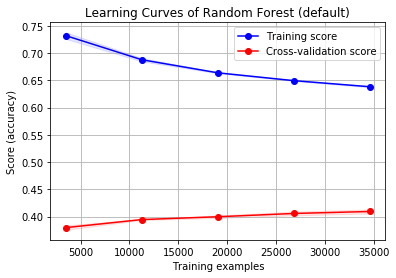

In [37]:
plot_learning_curve(RandomForestClassifier(random_state=21), 'Learning Curves of Random Forest (default)', X_train_best, y_train)
plt.show()

A slight high variance problem (overfitted) will occur when using the default Random Forest classifier. The training set starts of with high accuracy (as expected) but the accuracy doesn't decline much as the number of training examples increases. In contrast, the cross-validation score starts off with low accuracy and increases with very small amounts as the number of training examples increases. This high variance problem can be solved by evaluating different hyperparameters of the Random Forest classifier and using the results to fine-tune the classifier.

##### Hyperparameter evaluation
Show the validation curve of different hyperparamethers of the Random Forest classifiers (for both training and cross-validation set). The results will be used to select a range of hyperparameter to perform GridSearch on, which will fine tune the hyperparameters more efficiently.

*n_estimators*

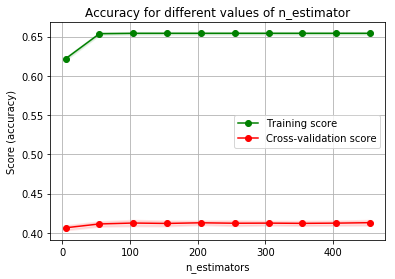

In [41]:
# Show validation curve for different values of hyperparameter 'n_estimators'
n_estimators = np.arange(5, 505, 50)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'Accuracy for different values of n_estimator', 
                      X_train_best, 
                      y_train, 
                      n_estimators, 
                      'n_estimators')
plt.show()

Increasing the hyperparameter 'n_estimators' seems to increase the accuracy of the training set between the values 0 and 100, which will add to the high variance problem. Also, increasing 'min_samples_split' doesn't seems to increase the accuracy of the cross-validation set very much. Becuase increasing 'n_estimators' doesn't seem te be necessary, the range between 10 and 200 will be used when performing GridSearch. 

*max_depth*

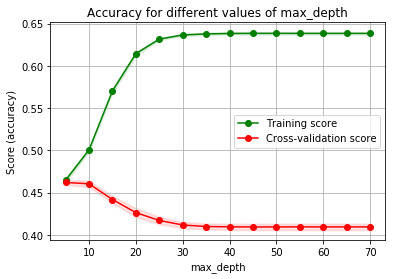

In [42]:
# Show validation curve for different values of hyperparameter 'max_depth'
max_depth = np.arange(5, 75, 5)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'Accuracy for different values of max_depth', 
                      X_train_best, 
                      y_train, 
                      max_depth, 
                      'max_depth')
plt.show()

Increasing the hyperparameter 'max_depth' seems to increase the accuracy of the training set between the values 0 and 30, which will add to the high variance problem. Also, increasing 'min_samples_split' does seem to decrease the accuracy of the cross-validation set between the values 0 and 30. Because an increase in 'max_depth' does almost instantly increase the high variance problem and decrease the accuracy, only the value 5 will be used when performing GridSearch.

*min_samples_split*

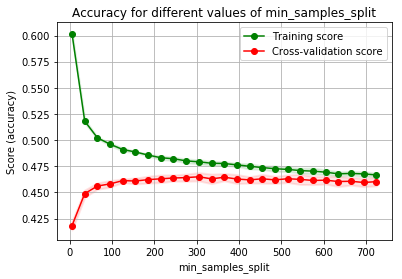

In [43]:
# Show validation curve for different values of hyperparameter 'min_samples_split'
min_samples_split = np.arange(5, 755, 30)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'Accuracy for different values of min_samples_split', 
                      X_train_best, 
                      y_train, 
                      min_samples_split, 
                      'min_samples_split')
plt.show()

Increasing the hyperparameter 'min_samples_split' seems to lower the accuracy of the training set, which will reduce the high variance problem. Increasing 'min_samples_split' also seems to increase the accuracy of the cross-validation set, with a plateau between de values 300 and 500. The range between 300 and 500 will therefore be used when performing GridSearch.

*min_samples_leaf*

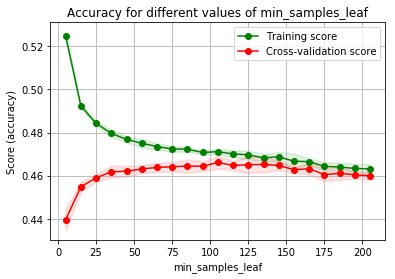

In [44]:
# Show validation curve for different values of hyperparameter 'min_samples_leaf'
min_samples_leaf = np.arange(5, 210, 10)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'Accuracy for different values of min_samples_leaf', 
                      X_train_best, 
                      y_train, 
                      min_samples_leaf, 
                      'min_samples_leaf')
plt.show()

Increasing the hyperparameter 'min_samples_leaf' seems to lower the accuracy of the training set, which will reduce the high variance problem. Increasing 'min_samples_leaf' also seems to increase the accuracy of the cross-validation set, with a plateau between de values 60 and 150. The range between 60 and 150 will therefore be used when performing GridSearch.

##### Finetune

In [48]:
n_estimators = np.arange(10, 240, 40)
max_depth = [5]
min_samples_split = np.arange(300, 520, 20)
min_samples_leaf = np.arange(60, 165, 15)

In [49]:
# Create the grid
rf_grid = { 'n_estimators': n_estimators,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf }
# Print grid
[print('%s: %s' % x) for x in rf_grid.items()];

n_estimators: [ 10  50  90 130 170 210]
max_depth: [5]
min_samples_split: [300 320 340 360 380 400 420 440 460 480 500]
min_samples_leaf: [ 60  75  90 105 120 135 150]


In [50]:
rf_clf = RandomForestClassifier(random_state=21)
rf_grid_search = GridSearchCV(estimator=rf_clf,
                             param_grid=rf_grid,
                             cv=5,
                             verbose=2,
                             n_jobs=-1)
# Fit the random search model
rf_grid_search = rf_grid_search.fit(X_train_best, y_train)

Fitting 5 folds for each of 462 candidates, totalling 2310 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 2310 out of 2310 | elapsed: 29.0min finished


In [51]:
# Print best cross-validated score
print('Mean cross-validated score of the best estimator: %0.3f' % (rf_grid_search.best_score_))
print('Improvement relative to default mean cross-validated score: : %0.3f' % (rf_grid_search.best_score_ - rf_clf_default_score))

# Show best parameters
best_rf_params = rf_grid_search.best_params_
best_rf_params

Mean cross-validated score of the best estimator: 0.464
Improvement relative to default mean cross-validated score: : 0.052


{'max_depth': 5,
 'min_samples_leaf': 135,
 'min_samples_split': 300,
 'n_estimators': 50}

In [52]:
# Instantiate Random Forest classifier using the best hyperparameters
rf_clf = rf_grid_search.best_estimator_ 

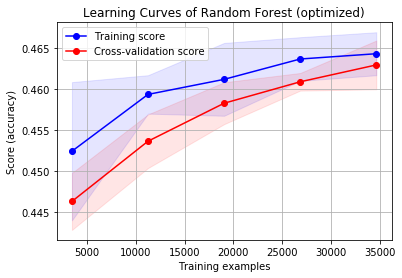

In [53]:
plot_learning_curve(rf_clf, 'Learning Curves of Random Forest (optimized)', X_train_best, y_train)
plt.show()

##### Metrics

In [54]:
rf_clf_metrics = metrics(X_test_best, y_test, rf_clf);

Accuracy on test set: 0.465
F1-score on test set: 0.314
Precision on test set: 0.421
Recall on test set: 0.309


In [55]:
print('Accuracy improvement of: %0.3f' % (rf_clf_metrics[0] - rf_clf_default_metrics[0]))
print('F1-score improvement of: %0.3f' % (rf_clf_metrics[1] - rf_clf_default_metrics[1]))
print('Precision improvement of: %0.3f' % (rf_clf_metrics[2] - rf_clf_default_metrics[2]))
print('Recall improvement of: %0.3f' % (rf_clf_metrics[3] - rf_clf_default_metrics[3]))

Accuracy improvement of: 0.052
F1-score improvement of: -0.003
Precision improvement of: 0.087
Recall improvement of: -0.002


#### 4.6.2. Support Vector Machine (SVM)

This time the Support Vector Machine (SVM) classifier will be used to predict the job satisfaction using the selected features.
First, the default SVM classifier will trained on the training set and evaltuated.
After the evaluation, a second SVM will be used to select the optimal hyperparameters.
The Random Forest classifier containing the optimal hyperparamaters will be evaluated on high variance (overfitting) and high bias (underfitting).<br>
The following hyperparameters will be optimized:
+ C: Penalty parameter C of the error term.
+ gamma: Kernel coefficient for 'rbf'.
+ kernel: The kernel type to be used in the algorithm ('linear', 'rbf').

In [56]:
from sklearn.svm import SVC

##### Default

In [57]:
svm_clf_default = SVC(random_state=21)
svm_clf_default_score = np.sum(cross_val_score(svm_clf_default, X_train_best, y_train, cv=5, n_jobs=-1)) / 5

print('Mean cross-validated score of SVM with default parameters: %0.3f' % (svm_clf_default_score))

Mean cross-validated score of SVM with default parameters: 0.451


In [58]:
svm_clf_default.fit(X_train_best, y_train)
svm_clf_default_metrics = metrics(X_test_best, y_test, svm_clf_default)

Accuracy on test set: 0.455
F1-score on test set: 0.418
Precision on test set: 0.447
Recall on test set: 0.473


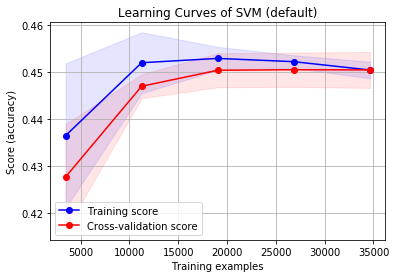

In [59]:
plot_learning_curve(SVC(random_state=21), 'Learning Curves of SVM (default)', X_train_best, y_train)
plt.show()

##### Hyperparameter evaluation

In [ ]:
# Show validation curve for different values of hyperparameter 'C'
C = np.logspace(-1, 3, 5)
plot_validation_curve(SVC(random_state=21),
                      'Accuracy for different values of C with RBF kernel', 
                      X_train_best, 
                      y_train, 
                      C, 
                      'C')
plt.show()

In [ ]:
# Show validation curve for different values of hyperparameter 'C'
C = np.logspace(-1, 3, 5)
plot_validation_curve(SVC(kernel='linear', random_state=21),
                      'Accuracy for different values of C with Linear kernel', 
                      X_train_best, 
                      y_train, 
                      C, 
                      'C')
plt.show()

In [ ]:
# Show validation curve for different values of hyperparameter 'gamma'
gamma = np.logspace(-2, 1, 4)
plot_validation_curve(SVC(random_state=21),
                      'Accuracy for different values of gamma for RBF kernel', 
                      X_train_best, 
                      y_train, 
                      gamma, 
                      'gamma')
plt.show()

##### Finetune

In [ ]:
C = np.logspace(-1, 3, 5)
gamma = np.logspace(-2, 1, 4)
kernel = ['linear', 'rbf']

In [ ]:
# Create the grid
svm_grid = { 'C': C,
           'gamma': gamma,
           'kernel': kernel }
# Print grid
[print('%s: %s' % x) for x in svm_grid.items()];

In [ ]:
svm_clf = SVC(random_state=21)
svm_grid_search = GridSearchCV(estimator=svm_clf,
                             param_grid=svm_grid,
                             cv=5,
                             verbose=2,
                             n_jobs=-1)
# Fit the random search model
svm_grid_search = svm_grid_search.fit(X_train_best, y_train)

In [ ]:
# Print best cross-validated score
print('Mean cross-validated score of the best estimator: %0.3f' % (svm_grid_search.best_score_))

# Show best parameters
best_svm_params = svm_grid_search.best_params_
best_svm_params

In [ ]:
# Instantiate SVM classifier using the best hyperparameters
svm_clf = svm_grid_search.best_estimator_ 

In [ ]:
plot_learning_curve(svm_clf, 'Learning Curves of SVM (default)', X_train_best, y_train)
plt.show()

In [ ]:
metrics(X_test_best, y_test, svm_clf)

#### 4.6.3. Multi-layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

##### Default

In [ ]:
mlp_clf_default = MLPClassifier()
mlp_clf_default_score = np.sum(cross_val_score(mlp_clf_default, X_train_best, y_train, cv=5)) / 5

print('Mean cross-validated score of MLP with default parameters: %0.3f' % (mlp_clf_default_score))

In [ ]:
mlp_clf_default.fit(X_train_best, y_train)
metrics(X_test_best, y_test, mlp_clf_default)

In [ ]:
plot_learning_curve(mlp_clf_default, 'Learning Curves of MLP (default)', X_train_best, y_train)
plt.show()

##### Finetune

In [ ]:
hidden_layer_sizes = [(50,50,50), (50,100,50), (100,)]
activation = ['tanh', 'relu']
solver = ['sgd', 'adam']
learning_rate = ['constant','adaptive']

In [ ]:
# Create the grid
mlp_grid = { 'hidden_layer_sizes': hidden_layer_sizes,
            'activation': activation,
            'solver': solver,
            'learning_rate': learning_rate }
# Print grid
[print('%s: %s' % x) for x in mlp_grid.items()];

In [ ]:
mlp_clf = MLPClassifier(max_iter=500)
mlp_grid_search = GridSearchCV(estimator=mlp_clf,
                             param_grid=mlp_grid,
                             cv=5,
                             verbose=2,
                             n_jobs=-1)
# Fit the random search model
mlp_grid_search = mlp_grid_search.fit(X_train_best, y_train)

In [ ]:
# Print best cross-validated score
print('Mean cross-validated score of the best estimator: %0.3f' % (mlp_grid_search.best_score_))

# Show best parameters
best_mlp_params = mlp_grid_search.best_params_
best_mlp_params

In [ ]:
# Instantiate SVM classifier using the best hyperparameters
mlp_clf = mlp_grid_search.best_estimator_ 

In [ ]:
plot_learning_curve(mlp_clf, 'Learning Curves of MLP (default)', X_train_best, y_train)
plt.show()

In [ ]:
metrics(X_test_best, y_test, mlp_clf)

### 4.7. Compare results

In [ ]:
from scipy import stats
from sklearn.ensemble import VotingClassifier

#### 4.7.1. metrics

In [ ]:
data = {
    'RF': metrics(X_test_best, y_test, rf_clf, show=False),
    'SVM': metrics(X_test_best, y_test, svm_clf, show=False),
    'MLP': metrics(X_test_best, y_test, mlp_clf, show=False),
}
metrics_df = pd.DataFrame(data, index=['Accuracy', 'F1', 'Precision', 'Recall'])
metrics_df

#### 4.7.2. Ensemble learning

In [ ]:
def ensemble_learning(X, y, classifiers):
    predictions = []
    clf_predictions = []
    clf_accuracies = []
    for i, classifier in enumerate(classifiers):
        y_pred = classifier.predict(X)
        clf_predictions.append(y_pred)
        clf_accuracies.append(accuracy_score(y, y_pred))
        
    for i in range(len(clf_predictions[0])):
        y_preds = []
        for j in range(len(clf_predictions)):
            y_preds.append(clf_predictions[j][i])
        mode = stats.mode(y_preds)[0]
        if len(mode) > 1:
            best_clf = np.argmax(clf_accuracies)
            predictions.append(y_preds[best_clf])
        else:
            predictions.append(mode)
    return predictions
        

In [ ]:
y_pred = ensemble_learning(X_test_best, y_test, [rf_clf, svm_clf, mlp_clf])

#eclf = VotingClassifier(estimators=[('rf', rf_clf), ('svm', svm_clf), ('mlp', mlp_clf)], voting='soft')
#eclf = eclf.fit(X_test_best, y_test)
#y_pred = eclf.predict(X_test_best)

In [ ]:
accuracy_score(y_test, y_pred)